In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from data import *
from hyperparameters import *
from small_dim import *
from optimal_bounds import *
import pandas as pd
import scipy.stats as stat
from tqdm import tqdm

### I - Influence of 𝛽 (2 tasks)

In [2]:
p = 200
nl = 50
nu = 125
n1 = nl+nu
n2 = 10*nl+nu
tt = 0
data = Data(p,[[n1,n1],[n2,n2]])
data.create_degrees([[nl,nl],[10*nl,10*nl]],[[nu,nu],[nu,nu]])
hp = HyperParameters(2)
pts = 20
BETA = np.linspace(-0.99, 0.99, pts) # Values of correlation
nb_iter = 100
E_naive_emp = np.zeros((pts,nb_iter))
E_opt_emp = np.zeros((pts,nb_iter))
E_naive_th = np.zeros((pts,nb_iter))
E_opt_th = np.zeros((pts,nb_iter))
y_naive = np.zeros((pts,nb_iter,4))
y_opt = np.zeros((pts,nb_iter,4))
best = np.zeros(pts)

In [3]:
mu_0 = np.zeros((2,p))
mu_0[0,0] = -0.5
mu_0[1,0] = 0.5
mu_1 = np.zeros((2,p))
mu_1[0,1] = -0.5
mu_1[1,1] = 0.5

In [4]:
MU = np.zeros((2,2,p))
MU[0] = mu_0
for i in tqdm(range(pts)):
    beta = BETA[i]
    MU[1] = beta*mu_0 + np.sqrt(1-beta**2)*mu_1
    hp.compute_lambda(data,'true',MU)
    Sigmas = 4/(np.linalg.norm(MU[:,0]-MU[:,1],axis=1,keepdims=True)@np.linalg.norm(MU[:,0]-MU[:,1],axis=1,keepdims=True).T)
    M = hp.lbd/Sigmas
    hp.compute_lambda(data,'true',MU)
    q = solution(data, M)
    best[i] = 1-stat.norm.cdf(np.sqrt(q[0]))
    for j in range(nb_iter):
        data.create_gaussian(MU)
        data.center()
        Mcal = data.Mcal('true',MU)
        hp.compute_alpha0(data)
        hp.optim_alpha(data,Mcal,tt)
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        y_opt[i,j] = labels_opti(a1, a2, B)
        y_naive[i,j] = [-1,1,-1,1]
        E_opt_th[i,j] = error_opti(a1, a2, B)
        E_naive_th[i,j] = np.mean(error_th(a1, a2, B, y_naive[i,j], tt, threshold=0))
        E_opt_emp[i,j] = np.mean(data.error_emp(hp, y_opt[i,j], tt, threshold=0))
        E_naive_emp[i,j] = np.mean(data.error_emp(hp, y_naive[i,j], tt, threshold=0))

100%|██████████| 20/20 [45:30<00:00, 93.71s/it]  


In [5]:
m_naive_emp = np.mean(E_naive_emp,axis=1)
s_naive_emp = np.sqrt(np.var(E_naive_emp,axis=1))/np.sqrt(nb_iter)
m_opt_emp = np.mean(E_opt_emp,axis=1)
s_opt_emp = np.sqrt(np.var(E_opt_emp,axis=1))/np.sqrt(nb_iter)
m_naive_th = np.mean(E_naive_th,axis=1)
m_opt_th = np.mean(E_opt_th,axis=1)
y_opt_plot = y_opt/np.linalg.norm(y_opt,axis=2,keepdims=True)*2
y_opt_plot = np.mean(y_opt_plot,axis=1)
y_naive_plot = np.mean(y_naive,axis=1)

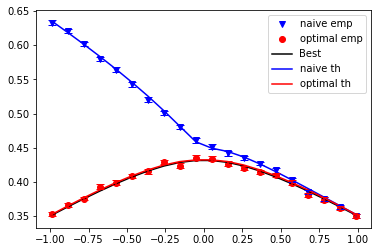

In [6]:
plt.plot(BETA, m_naive_emp, 'v', label='naive emp', color='b')
plt.plot(BETA, m_opt_emp, 'o', label='optimal emp', color='r')
plt.plot(BETA, best, label = 'Best', color = 'k')
plt.plot(BETA, m_naive_th, '-', label='naive th', color='b')
plt.plot(BETA, m_opt_th, '-', label='optimal th', color='r')
plt.errorbar(BETA, m_naive_emp, s_naive_emp, color='b', capsize=4, linestyle='')
plt.errorbar(BETA, m_opt_emp, s_opt_emp, color='r', capsize=4, linestyle='')
plt.legend()

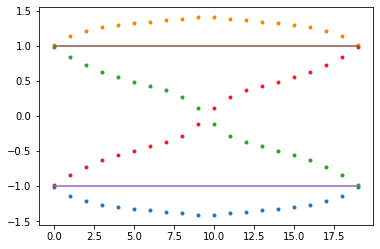

In [7]:
plt.plot(y_opt_plot[:,0],'.')
plt.plot(y_opt_plot[:,1],'.')
plt.plot(y_opt_plot[:,2],'.')
plt.plot(y_opt_plot[:,3],'.')
plt.plot(y_naive_plot[:,0])
plt.plot(y_naive_plot[:,1])

In [8]:
correlation_perf = pd.DataFrame({'beta': BETA, 'm_naive_th': m_naive_th, 'm_opt_th': m_opt_th, 'm_naive_emp': m_naive_emp, 'm_opt_emp': m_opt_emp, 's_naive_emp': s_naive_emp, 's_opt_emp': s_opt_emp, 'best': best})  
correlation_perf.to_csv('DATA/correlation_perf_2.dat',sep=' ',index=False)

In [9]:
correlation_labels = pd.DataFrame({'beta': BETA, 'y_opt_1_1': y_opt_plot[:,0], 'y_opt_1_2': y_opt_plot[:,1], 'y_opt_2_1': y_opt_plot[:,2], 'y_opt_2_2': y_opt_plot[:,3], 'y_naive_1': y_naive_plot[:,0], 'y_naive_2': y_naive_plot[:,1]})  
correlation_labels.to_csv('DATA/correlation_labels_2.dat',sep=' ',index=False)

### II - Influence of class imbalances (1 task)

In [10]:
p = 200
nl = 1000
nu = 200
NL = np.array([100,200,300,400,500,600,700,800,900])
n = nl+nu
tt = 0
hp = HyperParameters(1)
pts = len(NL)
nb_iter = 100
E_naive_emp = np.zeros((pts,nb_iter,2))
E_opt_emp = np.zeros((pts,nb_iter,2))
E_naive_th = np.zeros((pts,nb_iter,2))
E_opt_th = np.zeros((pts,nb_iter,2))
y_naive = np.zeros((pts,nb_iter,2))
y_opt = np.zeros((pts,nb_iter,2))
threshold_naive = np.zeros((pts,nb_iter))
threshold_opt = np.zeros((pts,nb_iter))
means_naive = np.zeros((pts,nb_iter,2))
means_opt = np.zeros((pts,nb_iter,2))
best = np.zeros(pts)

In [11]:
MU = np.zeros((1,2,p))
MU[0,0,0] = -1
MU[0,1,0] = 1

In [12]:
for i in tqdm(range(pts)):
    nl1 = NL[i]
    nl2 = nl-nl1
    n1 = nl1+nu
    n2 = nl2+nu
    data = Data(p,[[n1,n2]])
    data.create_degrees([[nl1,nl2]],[[nu,nu]])
    hp.compute_lambda(data,'true',MU)
    Sigmas = 4/(np.linalg.norm(MU[:,0]-MU[:,1],axis=1,keepdims=True)@np.linalg.norm(MU[:,0]-MU[:,1],axis=1,keepdims=True).T)
    M = hp.lbd/Sigmas
    hp.compute_lambda(data,'ord4',MU)
    q = solution(data, M)
    best[i] = 1-stat.norm.cdf(np.sqrt(q[0]))
    for j in range(nb_iter):
        data.create_gaussian(MU)
        data.center()
        Mcal = data.Mcal('true',MU)
        hp.compute_alpha0(data)
        hp.optim_alpha(data,Mcal,tt)
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        y_opt[i,j] = labels_opti(a1, a2, B)
        y_naive[i,j] = [-1,1]
        m1, m2 = np.dot(a1,y_opt[i,j]), np.dot(a2,y_opt[i,j])
        threshold_opt[i,j] = (m1+m2)/2
        threshold_naive[i,j] = 0
        E_opt_th[i,j] = error_th(a1, a2, B, y_opt[i,j], tt, threshold=threshold_opt[i,j])
        E_naive_th[i,j] = error_th(a1, a2, B, y_naive[i,j], tt, threshold=threshold_naive[i,j])
        E_opt_emp[i,j] = data.error_emp(hp, y_opt[i,j], tt, threshold=threshold_opt[i,j])
        E_naive_emp[i,j] = data.error_emp(hp, y_naive[i,j], tt, threshold=threshold_naive[i,j])
        threshold_opt[i,j] /= np.sqrt((m1**2+m2**2)/2)

100%|██████████| 9/9 [09:01<00:00, 59.89s/it]


In [13]:
m_naive_emp = np.mean(E_naive_emp,axis=1)
s_naive_emp = np.sqrt(np.var(E_naive_emp,axis=1))/np.sqrt(nb_iter)
m_opt_emp = np.mean(E_opt_emp,axis=1)
s_opt_emp = np.sqrt(np.var(E_opt_emp,axis=1))/np.sqrt(nb_iter)
m_naive_th = np.mean(E_naive_th,axis=1)
m_opt_th = np.mean(E_opt_th,axis=1)
y_opt_plot = y_opt/np.linalg.norm(y_opt,axis=2,keepdims=True)*np.sqrt(2)
y_opt_plot = np.mean(y_opt_plot,axis=1)
y_naive_plot = y_naive/np.linalg.norm(y_naive,axis=2,keepdims=True)*np.sqrt(2)
y_naive_plot = np.mean(y_naive_plot,axis=1)
threshold_naive_plot = np.mean(threshold_naive,axis=1)
threshold_opt_plot = np.mean(threshold_opt,axis=1)

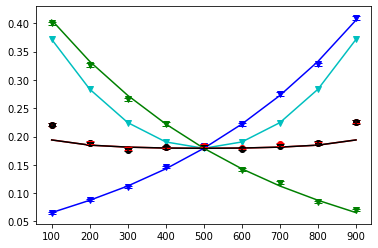

In [14]:
plt.plot(NL, m_naive_emp[:,0], 'v', label='naive emp C1', color='b')
plt.plot(NL, m_naive_emp[:,1], 'v', label='naive emp C2', color='g')
plt.plot(NL, m_naive_th[:,0]*NL/nl+m_naive_th[:,1]*(nl-NL)/nl, 'v', label='avg naive emp', color='c')
plt.plot(NL, m_opt_emp[:,0], 'o', label='optimal emp C1', color='r')
plt.plot(NL, m_opt_emp[:,1], 'o', label='optimal emp C2', color='k')
plt.plot(NL, m_naive_th[:,0], '-', label='naive th C1', color='b')
plt.plot(NL, m_naive_th[:,1], '-', label='naive th C2', color='g')
plt.plot(NL, m_naive_th[:,0]*NL/nl+m_naive_th[:,1]*(nl-NL)/nl, label='avg naive th', color='c')
plt.plot(NL, m_opt_th[:,0], '-', label='optimal th C1', color='r')
plt.plot(NL, m_opt_th[:,1], '-', label='optimal th C2', color='k')
plt.errorbar(NL, m_naive_emp[:,0], s_naive_emp[:,0], color='b', capsize=4, linestyle='')
plt.errorbar(NL, m_naive_emp[:,1], s_naive_emp[:,1], color='g', capsize=4, linestyle='')
plt.errorbar(NL, m_opt_emp[:,0], s_opt_emp[:,0], color='r', capsize=4, linestyle='')
plt.errorbar(NL, m_opt_emp[:,1], s_opt_emp[:,1], color='k', capsize=4, linestyle='');
#plt.legend()

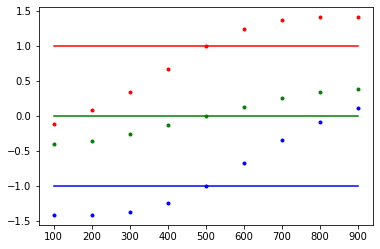

In [15]:
plt.plot(NL, y_opt_plot[:,0],'.',color='b')
plt.plot(NL, y_opt_plot[:,1],'.',color='r')
plt.plot(NL, y_naive_plot[:,0],color='b')
plt.plot(NL, y_naive_plot[:,1],color='r')
plt.plot(NL, threshold_naive_plot,color='g')
plt.plot(NL, threshold_opt_plot,'.',color='g')

In [16]:
class_imbalances = pd.DataFrame({'nl': NL, 'm_naive_th_1': m_naive_th[:,0], 'm_naive_th_2': m_naive_th[:,1],  'm_opt_th_1': m_opt_th[:,0], 'm_opt_th_2': m_opt_th[:,1], 'm_naive_th_avg': m_naive_th[:,0]*NL/nl+m_naive_th[:,1]*(nl-NL)/nl, 'm_naive_emp_1': m_naive_emp[:,0], 'm_naive_emp_2': m_naive_emp[:,1],  'm_opt_emp_1': m_opt_emp[:,0], 'm_opt_emp_2': m_opt_emp[:,1], 'm_naive_emp_avg': m_naive_emp[:,0]*NL/nl+m_naive_emp[:,1]*(nl-NL)/nl})  
class_imbalances.to_csv('DATA/class_imbalances.dat',sep=' ',index=False)

In [17]:
imbalances_labels = pd.DataFrame({'nl': NL, 'y_opt_1': y_opt_plot[:,0], 'y_opt_2': y_opt_plot[:,1], 'y_naive_1': y_naive_plot[:,0], 'y_naive_2': y_naive_plot[:,1], 'threshold_opt': threshold_opt_plot, 'threshold_naive': threshold_naive_plot})
imbalances_labels.to_csv('DATA/imbalances_labels.dat',sep=' ',index=False)

### III-1 : Number of uncertain data to overcome the lack of certain data

In [18]:
p = 200
nl_ini = 1
nu = 200
tt = 0
hp = HyperParameters(1)
CONF = np.array([0.5,0.6,0.75,0.9,1])
n = 10
NL = np.zeros((len(CONF),n),dtype=int)
NI = np.zeros((len(CONF),n))
n_bcp = 3000

In [19]:
MU = np.zeros((1,2,p))
MU[0,0,0] = -1
MU[0,1,0] = 1

In [20]:
# Creation of the data that will be used as a common basis
data_base = Data(p,[[n_bcp,n_bcp]])
data_base.create_gaussian(MU)
for i in range(len(CONF)):
    conf = CONF[i]
    NL[i,0], NL[i,-1] = 20, 400
    NL[i,1:n-1] = np.array(20+np.random.rand(n-2)*350,dtype=int)
    for j in range(n):
        # Computation of the reference error
        err_base = 0
        nf = nl_ini+NL[i,j]
        data = Data(p,[[nf+nu,nf+nu]])
        data.create_degrees([[nf,nf]],[[nu,nu]])
        Mcal = data.Mcal('true',MU)
        for j1 in range(2):
            data.samples[0][j1][:,0:nf] = data_base.samples[0][j1][:,0:nf]
            data.samples[0][j1][:,nf::] = data_base.samples[0][j1][:,n_bcp-nu:n_bcp]
        hp.compute_alpha0(data)
        hp.optim_alpha(data, Mcal, tt)
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        err_base = error_opti(a1, a2, B)
        # Computation of the number of imprecise data
        ni = 0
        pas = NL[i,j]
        while pas>0:
            nf = nl_ini 
            new_err = err_base+1
            while new_err>err_base:
                data = Data(p,[[nf+ni+nu,nf+ni+nu]])
                data.create_degrees([[nf+ni,nf+ni]],[[nu,nu]])
                for j1 in range(2):
                    data.samples[0][j1][:,0:nf+ni] = data_base.samples[0][j1][:,0:nf+ni]
                    data.samples[0][j1][:,nf+ni::] = data_base.samples[0][j1][:,n_bcp-nu:n_bcp]
                n1 = int(conf*ni)
                n2 = ni-n1
                data.degrees[0][0][0,nf:nf+ni] = np.concatenate([conf*np.ones(n1),(1-conf)*np.ones(n2)])
                data.degrees[0][0][1,nf:nf+ni] = np.concatenate([(1-conf)*np.ones(n1),conf*np.ones(n2)])
                data.degrees[0][1][0,nf:nf+ni] = np.concatenate([(1-conf)*np.ones(n1),conf*np.ones(n2)])
                data.degrees[0][1][1,nf:nf+ni] = np.concatenate([conf*np.ones(n1),(1-conf)*np.ones(n2)])
                hp.compute_alpha0(data)
                hp.optim_alpha(data, Mcal, tt)
                a1, a2, B = small_dim(data, hp, Mcal, tt)
                new_err = error_opti(a1, a2, B)
                ni += pas
                if nf+ni==700:
                    ni = 700-nf+1
            ni = ni - 2*pas
            pas = pas//2
        NI[i,j] = ni + 1
    print(CONF[i])

0.5
0.6
0.75
0.9
1.0


In [21]:
for i in range(len(CONF)):
    NL[i].sort()
    NI[i].sort()

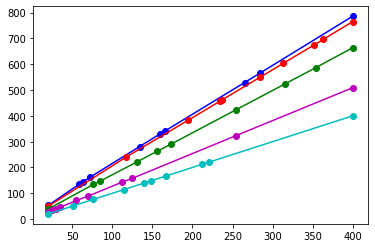

In [22]:
plt.plot(NL[0], NI[0], '-o', label='conf=0.5', color='b')
plt.plot(NL[1], NI[1], '-o', label='conf=0.6', color='r')
plt.plot(NL[2], NI[2], '-o', label='conf=0.75', color='g')
plt.plot(NL[3], NI[3], '-o', label='conf=0.9', color='m')
plt.plot(NL[4], NI[4], '-o', label='conf=1', color='c')

In [23]:
nb_donnees_sup = pd.DataFrame({'nl1': NL[0], 'ni1': NI[0], 'nl2': NL[1], 'ni2': NI[1], 'nl3': NL[2], 'ni3': NI[2], 'nl4': NL[3], 'ni4': NI[3], 'nl5': NL[4], 'ni5': NI[4]})  
nb_donnees_sup.to_csv('DATA/nb_donnees_sup.dat',sep=' ',index=False)

### III-2 : Number of uncertain data per certain data

In [24]:
p = 200
nl_ini = 1
nu = 200
tt = 0
hp = HyperParameters(1)
CONF = [0.5+0.05*i for i in range(11)]
NL = np.array([20,50,100,200,400])
DIFF = [0.25,0.5,0.75]
NI = np.zeros((len(DIFF),len(CONF),len(NL)))
n_bcp = 5000

In [25]:
for h in tqdm(range(len(DIFF))):
    MU = np.zeros((1,2,p))
    MU[0,0,0] = -1/(2*DIFF[h])
    MU[0,1,0] = 1/(2*DIFF[h])
    # Creation of the data that will be used as a common basis
    data_base = Data(p,[[n_bcp,n_bcp]])
    data_base.create_gaussian(MU)
    for i in range(len(CONF)):
        conf = CONF[i]
        for j in range(len(NL)):
            # Computation of the reference error
            err_base = 0
            nf = nl_ini+NL[j]
            data = Data(p,[[nf+nu,nf+nu]])
            data.create_degrees([[nf,nf]],[[nu,nu]])
            Mcal = data.Mcal('true',MU)
            for j1 in range(2):
                data.samples[0][j1][:,0:nf] = data_base.samples[0][j1][:,0:nf]
                data.samples[0][j1][:,nf::] = data_base.samples[0][j1][:,n_bcp-nu:n_bcp]
            hp.compute_alpha0(data)
            hp.optim_alpha(data, Mcal, tt)
            a1, a2, B = small_dim(data, hp, Mcal, tt)
            err_base = error_opti(a1, a2, B)
            # Computation of the number of imprecise data
            ni = 0
            pas = NL[j]
            while pas>0:
                nf = nl_ini 
                new_err = err_base+1
                while new_err>err_base:
                    data = Data(p,[[nf+ni+nu,nf+ni+nu]])
                    data.create_degrees([[nf+ni,nf+ni]],[[nu,nu]])
                    for j1 in range(2):
                        data.samples[0][j1][:,0:nf+ni] = data_base.samples[0][j1][:,0:nf+ni]
                        data.samples[0][j1][:,nf+ni::] = data_base.samples[0][j1][:,n_bcp-nu:n_bcp]
                    n1 = int(conf*ni)
                    n2 = ni-n1
                    data.degrees[0][0][0,nf:nf+ni] = np.concatenate([conf*np.ones(n1),(1-conf)*np.ones(n2)])
                    data.degrees[0][0][1,nf:nf+ni] = np.concatenate([(1-conf)*np.ones(n1),conf*np.ones(n2)])
                    data.degrees[0][1][0,nf:nf+ni] = np.concatenate([(1-conf)*np.ones(n1),conf*np.ones(n2)])
                    data.degrees[0][1][1,nf:nf+ni] = np.concatenate([conf*np.ones(n1),(1-conf)*np.ones(n2)])
                    hp.compute_alpha0(data)
                    hp.optim_alpha(data, Mcal, tt)
                    a1, a2, B = small_dim(data, hp, Mcal, tt)
                    new_err = error_opti(a1, a2, B)
                    ni += pas
                    if nf+ni==700:
                        ni = 700-nf+1
                ni = ni - 2*pas
                pas = pas//2
            NI[h,i,j] = ni + 1

100%|██████████| 3/3 [01:27<00:00, 28.72s/it]


In [26]:
P = np.zeros((len(DIFF),len(CONF),2))
Ratio = [[] for i in range(len(DIFF))]
for h in range(len(DIFF)):
    for i in range(len(CONF)):
        P[h,i] = np.polyfit(NL,NI[h,i],1)
        Ratio[h].append(1/P[h,i,0])
Ratio = np.array(Ratio)

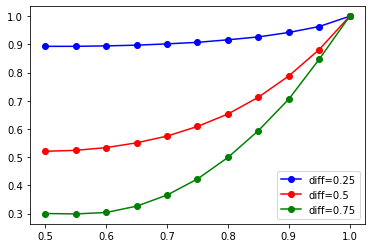

In [27]:
plt.plot(CONF, Ratio[0], 'o-', label='diff=0.25', color='b')
plt.plot(CONF, Ratio[1], 'o-', label='diff=0.5', color='r')
plt.plot(CONF, Ratio[2], 'o-', label='diff=0.75', color='g')
plt.legend()

In [28]:
ratio_conf = pd.DataFrame({'conf': CONF, 'ratio_1': Ratio[0], 'ratio_2': Ratio[1], 'ratio_3': Ratio[2]})
ratio_conf.to_csv('DATA/ratio_conf.dat',sep=' ',index=False)

### III-3 : $n_u$/$n_l$ as a function of difficulty

In [29]:
p = 200
nl_ini = 1
nu = 200
tt = 0
hp = HyperParameters(1)
CONF = [0.5,0.7,0.9]
NL = np.array([20,50,100,200,400])
DIFF = np.arange(0.25,1.51,0.25/3)#DIFF = np.arange(0.2,1.51,0.1)
NI = np.zeros((len(DIFF),len(CONF),len(NL)))
n_bcp = 20000

In [30]:
for h in tqdm(range(len(DIFF))):
    MU = np.zeros((1,2,p))
    MU[0,0,0] = -1/(2*DIFF[h])
    MU[0,1,0] = 1/(2*DIFF[h])
    # Creation of the data that will be used as a common basis
    data_base = Data(p,[[n_bcp,n_bcp]])
    data_base.create_gaussian(MU)
    for i in range(len(CONF)):
        conf = CONF[i]
        for j in range(len(NL)):
            # Computation of the reference error
            err_base = 0
            nf = nl_ini+NL[j]
            data = Data(p,[[nf+nu,nf+nu]])
            data.create_degrees([[nf,nf]],[[nu,nu]])
            Mcal = data.Mcal('true',MU)
            for j1 in range(2):
                data.samples[0][j1][:,0:nf] = data_base.samples[0][j1][:,0:nf]
                data.samples[0][j1][:,nf::] = data_base.samples[0][j1][:,n_bcp-nu:n_bcp]
            hp.compute_alpha0(data)
            hp.optim_alpha(data, Mcal, tt)
            a1, a2, B = small_dim(data, hp, Mcal, tt)
            err_base = error_opti(a1, a2, B)
            # Computation of the number of imprecise data
            ni = 0
            pas = NL[j]
            while pas>0:
                nf = nl_ini 
                new_err = err_base+1
                while new_err>err_base:
                    data = Data(p,[[nf+ni+nu,nf+ni+nu]])
                    data.create_degrees([[nf+ni,nf+ni]],[[nu,nu]])
                    for j1 in range(2):
                        data.samples[0][j1][:,0:nf+ni] = data_base.samples[0][j1][:,0:nf+ni]
                        data.samples[0][j1][:,nf+ni::] = data_base.samples[0][j1][:,n_bcp-nu:n_bcp]
                    n1 = int(conf*ni)
                    n2 = ni-n1
                    data.degrees[0][0][0,nf:nf+ni] = np.concatenate([conf*np.ones(n1),(1-conf)*np.ones(n2)])
                    data.degrees[0][0][1,nf:nf+ni] = np.concatenate([(1-conf)*np.ones(n1),conf*np.ones(n2)])
                    data.degrees[0][1][0,nf:nf+ni] = np.concatenate([(1-conf)*np.ones(n1),conf*np.ones(n2)])
                    data.degrees[0][1][1,nf:nf+ni] = np.concatenate([conf*np.ones(n1),(1-conf)*np.ones(n2)])
                    hp.compute_alpha0(data)
                    hp.optim_alpha(data, Mcal, tt)
                    a1, a2, B = small_dim(data, hp, Mcal, tt)
                    new_err = error_opti(a1, a2, B)
                    ni += pas
                    if nf+ni==700:
                        ni = 700-nf+1
                ni = ni - 2*pas
                pas = pas//2
            NI[h,i,j] = ni + 1

100%|██████████| 16/16 [03:53<00:00, 25.44s/it]


In [31]:
P = np.zeros((len(DIFF),len(CONF),2))
Ratio = [[] for i in range(len(CONF))]
for h in range(len(DIFF)):
    for i in range(len(CONF)):
        P[h,i] = np.polyfit(NL,NI[h,i],1)
        Ratio[i].append(1/P[h,i,0])
Ratio = np.array(Ratio)

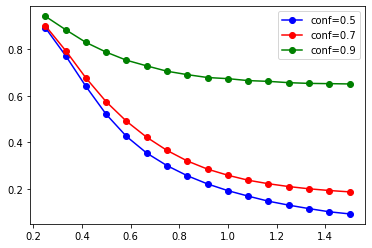

In [32]:
plt.plot(DIFF, Ratio[0], 'o-', label='conf=0.5', color='b')
plt.plot(DIFF, Ratio[1], 'o-', label='conf=0.7', color='r')
plt.plot(DIFF, Ratio[2], 'o-', label='conf=0.9', color='g')
plt.legend()

In [33]:
ratio_diff = pd.DataFrame({'diff': DIFF, 'ratio_1': Ratio[0], 'ratio_2': Ratio[1], 'ratio_3': Ratio[2]})
ratio_diff.to_csv('DATA/ratio_diff.dat',sep=' ',index=False)